In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpy.typing as npt
from matplotlib.collections import Collection
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from quant_met import mean_field, geometry, parameters

In [2]:
WIDTH = 5.6
plt.style.use(['./thesis.mplstyle', "petroff10"])

In [3]:
graphene_lattice = geometry.GrapheneLattice(lattice_constant=np.sqrt(3))
graphene_lattice._high_symmetry_points = ((graphene_lattice.Gamma, r"\Gamma"), (graphene_lattice.M, "M"), (graphene_lattice.K, "K"), (graphene_lattice.Gamma, r"\Gamma"))
n = 1000  # number of points across the whole k space path
t_gr = 1
t_x = 0
band_path, band_path_plot, ticks, labels = graphene_lattice.generate_high_symmetry_path(number_of_points=n)

In [4]:
def plot_bandstructure(
        bands: npt.NDArray[np.floating],
        k_point_list: npt.NDArray[np.floating],
        ticks: list[float],
        labels: list[str],
        overlaps: npt.NDArray[np.floating] | None = None,
        overlap_labels: list[str] | None = None,
        fig_in: matplotlib.figure.Figure | None = None,
        ax_in: matplotlib.axes.Axes | None = None,
) -> matplotlib.figure.Figure:
    """Plot bands along a k space path.

    To have a plot that respects the distances in k space and generate everything that is needed for
    plotting, use the function :func:`~quant_met.plotting.generate_bz_path`.

    Parameters
    ----------
    bands : :class:`numpy.ndarray`
    k_point_list : :class:`numpy.ndarray`
        List of points to plot against. This is not a list of two-dimensional k-points!
    ticks : list(float)
        Position for ticks.
    labels : list(str)
        Labels on ticks.
    overlaps : :class:`numpy.ndarray`, optional
        Overlaps.
    overlap_labels : list(str), optional
        Labels to put on overlaps.
    fig_in : :class:`matplotlib.figure.Figure`, optional
        Figure that holds the axes. If not provided, a new figure and ax is created.
    ax_in : :class:`matplotlib.axes.Axes`, optional
        Ax to plot the data in. If not provided, a new figure and ax is created.

    Returns
    -------
    :obj:`matplotlib.figure.Figure`
        Figure with the data plotted onto the axis.

    """
    if fig_in is None or ax_in is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = fig_in, ax_in

    ax.axhline(y=0, alpha=0.7, linestyle="--", color="black")

    if overlaps is None:
        for band in bands:
            ax.plot(k_point_list, band)
    else:
        line = Collection()
        for band, wx in zip(bands, overlaps, strict=True):
            points = np.array([k_point_list, band]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            norm = matplotlib.colors.Normalize(-1, 1)
            lc = LineCollection(segments, cmap="coolwarm", norm=norm)
            lc.set_array(wx)
            lc.set_linewidth(1.5)
            line = ax.add_collection(lc)


    ax.set_ylim(
        top=float(np.max(bands) + 0.1 * np.max(bands)),
        bottom=float(np.min(bands) - 0.1 * np.abs(np.min(bands))),
    )
    ax.set_xticks(ticks, labels)

    return fig, line

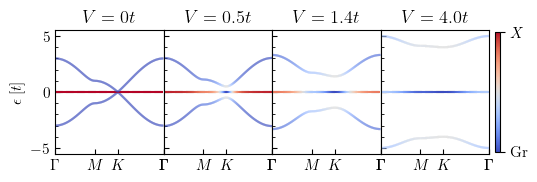

In [5]:
from matplotlib.ticker import AutoMinorLocator

V_list = [0, 0.5, 1.4, 4]

fig, axs = plt.subplots(nrows=1, ncols=len(V_list), figsize=(WIDTH, WIDTH / 3.5), sharey=True)

fig.subplots_adjust(wspace=0)

for V, ax in zip(V_list, axs):
    dressed_graphene_h = mean_field.hamiltonians.DressedGraphene(
        parameters=parameters.DressedGrapheneParameters(
            hopping_gr=t_gr, hopping_x=t_x, hopping_x_gr_a=V, lattice_constant=graphene_lattice.lattice_constant, chemical_potential=0, hubbard_int_orbital_basis=[0.0, 0.0, 0.0]
        )
    )
    
    band_structure = dressed_graphene_h.calculate_bandstructure(band_path, overlaps=np.array([[0, 0, 1], [1, 0, 0], [0, 1, 0]]))
    
    bands = band_structure[['band_0', 'band_1', 'band_2']]
    overlaps = band_structure[['wx_0', 'wx_1', 'wx_2']]

    fig, line = plot_bandstructure(bands=bands.to_numpy().T, overlaps=overlaps.to_numpy().T, k_point_list=band_path_plot, ticks=ticks, labels=labels, ax_in=ax, fig_in=fig, overlap_labels=[r"$w_{\mathrm{Gr}_1}$", r"$w_X$"])

    overlap_labels = [r"$\mathrm{Gr}$", r"$X$"]

    if V == 0.0:
        ax.set_title(fr'$V = {V:.0f} t$')
    else:
        ax.set_title(fr'$V = {V:.1f} t$')
    ax.tick_params(axis='x')
    ax.tick_params(which="both", direction="in")
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

cbar_ax = fig.add_axes([0.91, 0.12, 0.01, 0.75])
##colorbar = fig.colorbar(line, fraction=0.046, pad=0.04, ax=ax)
colorbar = fig.colorbar(line, fraction=0.2, pad=0, cax=cbar_ax)
color_ticks = [-1, 1]
colorbar.set_ticks(ticks=color_ticks, labels=overlap_labels)


ax = axs[0]
ax.set_ylabel(r'$\epsilon\; [t]$')


fig.savefig('dressed graphene bands.pgf', bbox_inches="tight")

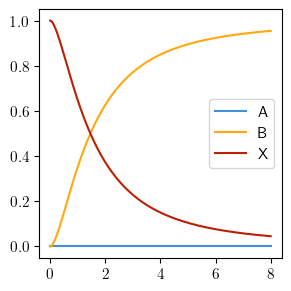

In [6]:
V_list = np.linspace(0, 8, num=250)

weight_gr_a_list = np.zeros(shape=V_list.shape, dtype=float)
weight_gr_b_list = np.zeros(shape=V_list.shape, dtype=float)
weight_gr_x_list = np.zeros(shape=V_list.shape, dtype=float)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(WIDTH / 2, WIDTH / 2), layout="constrained")

for V_index, V in enumerate(V_list):
    dressed_graphene_h = mean_field.hamiltonians.DressedGraphene(
        parameters=parameters.DressedGrapheneParameters(
            hopping_gr=t_gr, hopping_x=t_x, hopping_x_gr_a=V, lattice_constant=graphene_lattice.lattice_constant, chemical_potential=0, hubbard_int_orbital_basis=[0.0, 0.0, 0.0]
        )
    )
    k_list = dressed_graphene_h.lattice.generate_bz_grid(ncols=30, nrows=30)
    evals, evectors = dressed_graphene_h.diagonalize_nonint(k=k_list)

    weight_gr_a = 0
    weight_gr_b = 0
    weight_gr_x = 0
    for k_index in range(len(k_list)):
        weight_gr_a += np.abs(
            np.dot(evectors[k_index, :, 1], np.array([1, 0, 0]))
        )**2
        weight_gr_b += np.abs(
            np.dot(evectors[k_index, :, 1], np.array([0, 1, 0]))
        )**2
        weight_gr_x += np.abs(
            np.dot(evectors[k_index, :, 1], np.array([0, 0, 1]))
        )**2

    weight_gr_a_list[V_index] = weight_gr_a / len(k_list)
    weight_gr_b_list[V_index] = weight_gr_b / len(k_list)
    weight_gr_x_list[V_index] = weight_gr_x / len(k_list)

ax.plot(V_list, weight_gr_a_list, label="A")
ax.plot(V_list, weight_gr_b_list, label="B")
ax.plot(V_list, weight_gr_x_list, label="X")

ax.legend()

fig.savefig('dressed graphene orbital weight.pgf')